In [1]:
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import os
from sklearn.ensemble import RandomForestClassifier
import skimage
from skimage import transform

2023-04-20 23:18:09.874169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define the Expected Value matrix values
values = np.array([[7000, -7730, -14300, -1440],
                   [-2800, -30, -1600, -4240],
                   [-8200, -4430, 4000, -13240],
                   [-10960, -25470, -25040, 21200]])

### Cluster

In [3]:
# Set the path to the dataset folder containing subfolders for each class
data_dir = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Define image size
image_size = (200, 200)

# Define the order in which to process the classes
class_order = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Load dataset
def load_images_and_labels(data_dir, image_size):
    print("Loading images and labels...")
    images, labels = [], []
    for class_label, class_name in enumerate(class_order):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):  # Check if the file is a directory
            print("Processing images in directory:", class_dir)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                if os.path.isfile(image_path):  # Check if the file is an image file
                    image = load_img(image_path, target_size=image_size)
                    image_array = img_to_array(image) / 255.0
                    images.append(image_array)
                    labels.append(class_label)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_dir, image_size)

Loading images and labels...
Processing images in directory: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst
Processing images in directory: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal
Processing images in directory: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone
Processing images in directory: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor


In [4]:
# Prepare the data for clustering and logistic regression
X = images.reshape(len(images), -1)
y = labels

# Cluster the data into 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
labels_pred = kmeans.fit_predict(X)

# Print the number of images in each cluster
unique_labels, counts = np.unique(labels_pred, return_counts=True)
for i in range(len(unique_labels)):
    print(f"Cluster {unique_labels[i]}: {counts[i]} images")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: 8206 images
Cluster 1: 4240 images


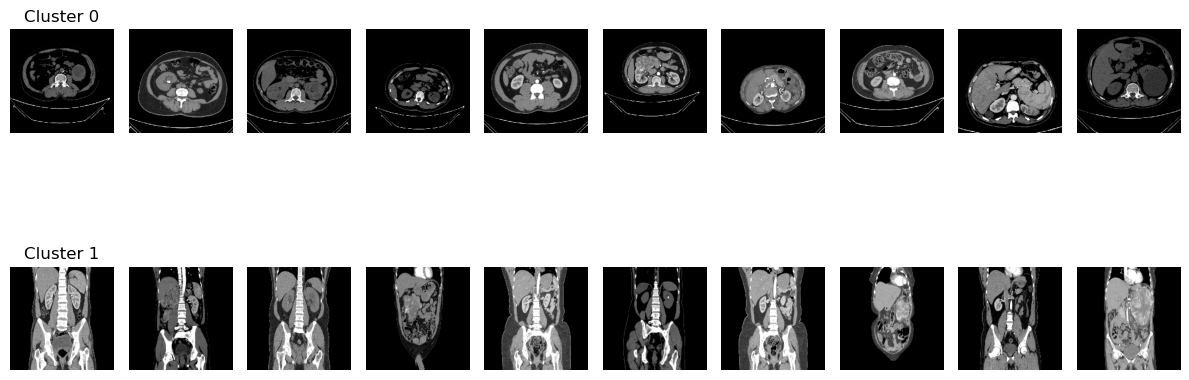

In [5]:
# Print 10 image samples for each cluster
num_samples = 10
fig, axs = plt.subplots(2, num_samples, figsize=(12, 6))
for i in range(2):
    cluster_indices = np.where(labels_pred == i)[0]
    sample_indices = np.random.choice(cluster_indices, num_samples, replace=False)
    for j, idx in enumerate(sample_indices):
        axs[i, j].imshow(images[idx])
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(f"Cluster {i}")
plt.tight_layout()
plt.show()

In [6]:
# Prepare the data for logistic regression for cluster 0
X_cluster0 = X[labels_pred == 0]
y_cluster0 = y[labels_pred == 0]

# Split the data into training and validation sets for cluster 0
X_val_cluster0, X_test_cluster0, y_val_cluster0, y_test_cluster0 = train_test_split(X_cluster0, y_cluster0, test_size=0.1, random_state=42)
X_train_cluster0, X_val_cluster0, y_train_cluster0, y_val_cluster0 = train_test_split(X_val_cluster0, y_val_cluster0, test_size=0.1, random_state=42)

In [7]:
# Prepare the data for logistic regression for cluster 1
X_cluster1 = X[labels_pred == 1]
y_cluster1 = y[labels_pred == 1]

# Split the data into training and validation sets for cluster 1
X_val_cluster1, X_test_cluster1, y_val_cluster1, y_test_cluster1 = train_test_split(X_cluster1, y_cluster1, test_size=0.1, random_state=42)
X_train_cluster1, X_val_cluster1, y_train_cluster1, y_val_cluster1 = train_test_split(X_val_cluster1, y_val_cluster1, test_size=0.1, random_state=42)

### Logistic Regression

In [8]:
# Train the logistic regression model for cluster 0
lr_cluster0 = LogisticRegression(multi_class='ovr', max_iter=500, solver='lbfgs')
lr_cluster0.fit(X_train_cluster0, y_train_cluster0)

# Evaluate the model on the validation set for cluster 0
y_val_pred_cluster0 = lr_cluster0.predict(X_val_cluster0)
y_test_pred_cluster0 = lr_cluster0.predict(X_test_cluster0)
val_accuracy_cluster0 = accuracy_score(y_val_cluster0, y_val_pred_cluster0)
test_accuracy_cluster0 = accuracy_score(y_test_cluster0, y_test_pred_cluster0)
print(f"Cluster 0 validation accuracy: {val_accuracy_cluster0:.4f}")
print(f"Cluster 0 test accuracy: {test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the validation set for cluster 0
val_cm_cluster0 = confusion_matrix(y_val_cluster0, y_val_pred_cluster0)
print("Cluster 0 validation confusion matrix:")
print(val_cm_cluster0)

# Multiply the values matrix with the validation confusion matrix
expected_val_cm_cluster0 = values * val_cm_cluster0
print("Expected value matrix for cluster 0 validation:")
print(expected_val_cm_cluster0)

# Sum the expected value matrix for cluster 0 validation
sum_expected_val_cm_cluster0 = np.sum(expected_val_cm_cluster0)
print("Sum of expected value matrix for cluster 0 validation:", sum_expected_val_cm_cluster0)

# Print the confusion matrix for the test set for cluster 0
test_cm_cluster0 = confusion_matrix(y_test_cluster0, y_test_pred_cluster0)
print("Cluster 0 test confusion matrix:")
print(test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_val_cm_test_cluster0 = values * test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_val_cm_test_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_val_cm_test_cluster0 = np.sum(expected_val_cm_test_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_val_cm_test_cluster0)

Cluster 0 validation accuracy: 1.0000
Cluster 0 test accuracy: 1.0000
Cluster 0 validation confusion matrix:
[[251   0   0   0]
 [  0 328   0   0]
 [  0   0  58   0]
 [  0   0   0 102]]
Expected value matrix for cluster 0 validation:
[[1757000       0       0       0]
 [      0   -9840       0       0]
 [      0       0  232000       0]
 [      0       0       0 2162400]]
Sum of expected value matrix for cluster 0 validation: 4141560
Cluster 0 test confusion matrix:
[[258   0   0   0]
 [  0 322   0   0]
 [  0   0  93   0]
 [  0   0   0 148]]
Expected value matrix for cluster 0 test:
[[1806000       0       0       0]
 [      0   -9660       0       0]
 [      0       0  372000       0]
 [      0       0       0 3137600]]
Sum of expected value matrix for cluster 0 test: 5305940


In [9]:
# Train the logistic regression model for cluster 1
lr_cluster1 = LogisticRegression(multi_class='ovr', max_iter=500, solver='lbfgs')
lr_cluster1.fit(X_train_cluster1, y_train_cluster1)

# Evaluate the model on the validation set for cluster 1
y_val_pred_cluster1 = lr_cluster1.predict(X_val_cluster1)
y_test_pred_cluster1 = lr_cluster1.predict(X_test_cluster1)
val_accuracy_cluster1 = accuracy_score(y_val_cluster1, y_val_pred_cluster1)
test_accuracy_cluster1 = accuracy_score(y_test_cluster1, y_test_pred_cluster1)
print(f"Cluster 1 validation accuracy: {val_accuracy_cluster1:.4f}")
print(f"Cluster 1 test accuracy: {test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the validation set for cluster 1
val_cm_cluster1 = confusion_matrix(y_val_cluster1, y_val_pred_cluster1)
print("Cluster 1 validation confusion matrix:")
print(val_cm_cluster1)

# Multiply the values matrix with the validation confusion matrix
expected_val_cm_cluster1 = values * val_cm_cluster1
print("Expected value matrix for cluster 0 validation:")
print(expected_val_cm_cluster1)

# Sum the expected value matrix for cluster 0 validation
sum_expected_val_cm_cluster1 = np.sum(expected_val_cm_cluster1)
print("Sum of expected value matrix for cluster 0 validation:", sum_expected_val_cm_cluster1)

# Print the confusion matrix for the test set for cluster 1
test_cm_cluster1 = confusion_matrix(y_test_cluster1, y_test_pred_cluster1)
print("Cluster 1 test confusion matrix:")
print(test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_val_cm_test_cluster1 = values * test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_val_cm_test_cluster1)

# Sum the expected value matrix for cluster 0 test
sum_expected_val_cm_test_cluster1 = np.sum(expected_val_cm_test_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_val_cm_test_cluster1)

Cluster 1 validation accuracy: 1.0000
Cluster 1 test accuracy: 1.0000
Cluster 1 validation confusion matrix:
[[ 88   0   0   0]
 [  0 173   0   0]
 [  0   0  42   0]
 [  0   0   0  79]]
Expected value matrix for cluster 0 validation:
[[ 616000       0       0       0]
 [      0   -5190       0       0]
 [      0       0  168000       0]
 [      0       0       0 1674800]]
Sum of expected value matrix for cluster 0 validation: 2453610
Cluster 1 test confusion matrix:
[[121   0   0   0]
 [  0 173   0   0]
 [  0   0  44   0]
 [  0   0   0  86]]
Expected value matrix for cluster 1 test:
[[ 847000       0       0       0]
 [      0   -5190       0       0]
 [      0       0  176000       0]
 [      0       0       0 1823200]]
Sum of expected value matrix for cluster 1 test: 2841010


In [10]:
def add_noise(image, noise_factor=0.1):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0., 1.)

# Add noise to the test dataset
noisy_X_test_cluster0 = np.array([add_noise(img.reshape(200, 200, 3)) for img in X_test_cluster0])

# Reshape the noisy images back to the flattened shape
noisy_X_test_cluster0 = noisy_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy test dataset
noisy_y_pred_cluster0 = lr_cluster0.predict(noisy_X_test_cluster0)

# Calculate accuracy on the noisy test dataset
noisy_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, noisy_y_pred_cluster0)
print(f"Noisy test accuracy_cluster0: {noisy_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the test set
noisy_test_cm_cluster0 = confusion_matrix(y_test_cluster0, noisy_y_pred_cluster0)
print("Noisy test confusion matrix_cluster0:")
print(noisy_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster0 = values * noisy_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster0 = np.sum(expected_noisy_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_test_cm_cluster0)

Noisy test accuracy_cluster0: 1.0000
Noisy test confusion matrix_cluster0:
[[258   0   0   0]
 [  0 322   0   0]
 [  0   0  93   0]
 [  0   0   0 148]]
Expected value matrix for cluster 0 test:
[[1806000       0       0       0]
 [      0   -9660       0       0]
 [      0       0  372000       0]
 [      0       0       0 3137600]]
Sum of expected value matrix for cluster 0 test: 5305940


In [11]:
def add_noise(image, noise_factor=0.1):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0., 1.)

# Add noise to the test dataset
noisy_X_test_cluster1 = np.array([add_noise(img.reshape(200, 200, 3)) for img in X_test_cluster1])

# Reshape the noisy images back to the flattened shape
noisy_X_test_cluster1 = noisy_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy test dataset
noisy_y_pred_cluster1 = lr_cluster1.predict(noisy_X_test_cluster1)

# Calculate accuracy on the noisy test dataset
noisy_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, noisy_y_pred_cluster1)
print(f"Noisy test accuracy_cluster1: {noisy_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the test set
noisy_test_cm_cluster1 = confusion_matrix(y_test_cluster1, noisy_y_pred_cluster1)
print("Noisy test confusion matrix_cluster1:")
print(noisy_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster1 = values * noisy_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_test_cm_cluster1)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster1 = np.sum(expected_noisy_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_test_cm_cluster1)

Noisy test accuracy_cluster1: 1.0000
Noisy test confusion matrix_cluster1:
[[121   0   0   0]
 [  0 173   0   0]
 [  0   0  44   0]
 [  0   0   0  86]]
Expected value matrix for cluster 1 test:
[[ 847000       0       0       0]
 [      0   -5190       0       0]
 [      0       0  176000       0]
 [      0       0       0 1823200]]
Sum of expected value matrix for cluster 1 test: 2841010


In [12]:
# Define the rotation function
def rotate(image, angle):
    rotated_image = transform.rotate(image, angle)
    return rotated_image

# Reshape the images
X_test_cluster0_re = X_test_cluster0.reshape(-1, 200, 200, 3)

# Define the rotation angle (degrees)
angle = 5

# Rotate the test images
rotate_X_test_cluster0 = np.array([rotate(img, angle=angle) for img in X_test_cluster0_re])

# Reshape the rotated images back to the flattened shape
rotate_X_test_cluster0 = rotate_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the rotated test dataset
rotate_y_pred_cluster0 = lr_cluster0.predict(rotate_X_test_cluster0)

# Calculate accuracy on the rotated test dataset
rotate_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, rotate_y_pred_cluster0)
print(f"rotated test accuracy: {rotate_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the rotated test set
rotate_test_cm_cluster0 = confusion_matrix(y_test_cluster0, rotate_y_pred_cluster0)
print("confusion matrix for rotated test dataset:")
print(rotate_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_rotate_test_cm_cluster0 = values * rotate_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_rotate_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_rotate_test_cm_cluster0 = np.sum(expected_rotate_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_rotate_test_cm_cluster0)

rotated test accuracy: 0.9184
confusion matrix for rotated test dataset:
[[256   0   2   0]
 [  3 319   0   0]
 [ 14   3  76   0]
 [ 13  32   0 103]]
Expected value matrix for cluster 0 test:
[[1792000       0  -28600       0]
 [  -8400   -9570       0       0]
 [-114800  -13290  304000       0]
 [-142480 -815040       0 2183600]]
Sum of expected value matrix for cluster 0 test: 3147420


In [13]:
# Define the rotation function
def rotate(image, angle):
    rotated_image = transform.rotate(image, angle)
    return rotated_image

# Reshape the images
X_test_cluster1_re = X_test_cluster1.reshape(-1, 200, 200, 3)

# Define the rotation angle (degrees)
angle = 5

# Rotate the test images
rotate_X_test_cluster1 = np.array([rotate(img, angle=angle) for img in X_test_cluster1_re])

# Reshape the rotated images back to the flattened shape
rotate_X_test_cluster1 = rotate_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the rotated test dataset
rotate_y_pred_cluster1 = lr_cluster1.predict(rotate_X_test_cluster1)

# Calculate accuracy on the rotated test dataset
rotate_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, rotate_y_pred_cluster1)
print(f"rotated test accuracy: {rotate_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the rotated test set
rotate_test_cm_cluster1 = confusion_matrix(y_test_cluster1, rotate_y_pred_cluster1)
print("confusion matrix for rotated test dataset:")
print(rotate_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_rotate_test_cm_cluster1 = values * rotate_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_rotate_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_rotate_test_cm_cluster1 = np.sum(expected_rotate_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_rotate_test_cm_cluster1)

rotated test accuracy: 0.8278
confusion matrix for rotated test dataset:
[[119   0   2   0]
 [  0 170   0   3]
 [ 15  10  17   2]
 [ 15  26   0  45]]
Expected value matrix for cluster 1 test:
[[ 833000       0  -28600       0]
 [      0   -5100       0  -12720]
 [-123000  -44300   68000  -26480]
 [-164400 -662220       0  954000]]
Sum of expected value matrix for cluster 1 test: 788180


In [14]:
def add_noise_and_rotate(image, noise_factor=0.1, angle=5):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster0 = np.array([add_noise_and_rotate(img) for img in X_test_cluster0_re])
noisy_rotated_X_test_flat_cluster0 = noisy_rotated_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster0 = lr_cluster0.predict(noisy_rotated_X_test_flat_cluster0)
noisy_rotated_y_pred_labels_cluster0 = noisy_rotated_y_pred_cluster0

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster0 = confusion_matrix(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_rotated_test_cm_cluster0 = values * noisy_rotated_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_rotated_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_rotated_test_cm_cluster0 = np.sum(expected_noisy_rotated_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_rotated_test_cm_cluster0)

Noisy and rotated test accuracy: 0.8855
Confusion matrix for noisy and rotated test dataset:
[[257   0   1   0]
 [  7 315   0   0]
 [ 37   2  54   0]
 [ 16  31   0 101]]
Expected value matrix for cluster 0 test:
[[1799000       0  -14300       0]
 [ -19600   -9450       0       0]
 [-303400   -8860  216000       0]
 [-175360 -789570       0 2141200]]
Sum of expected value matrix for cluster 0 test: 2835660


In [15]:
def add_noise_and_rotate(image, noise_factor=0.1, angle=5):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster1 = np.array([add_noise_and_rotate(img) for img in X_test_cluster1_re])
noisy_rotated_X_test_flat_cluster1 = noisy_rotated_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster1 = lr_cluster1.predict(noisy_rotated_X_test_flat_cluster1)
noisy_rotated_y_pred_labels_cluster1 = noisy_rotated_y_pred_cluster1

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster1 = confusion_matrix(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_rotated_test_cm_cluster1 = values * noisy_rotated_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_rotated_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_noisy_rotated_test_cm_cluster1 = np.sum(expected_noisy_rotated_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_rotated_test_cm_cluster1)

Noisy and rotated test accuracy: 0.8160
Confusion matrix for noisy and rotated test dataset:
[[119   0   2   0]
 [  0 171   0   2]
 [ 15   9  18   2]
 [ 15  33   0  38]]
Expected value matrix for cluster 1 test:
[[ 833000       0  -28600       0]
 [      0   -5130       0   -8480]
 [-123000  -39870   72000  -26480]
 [-164400 -840510       0  805600]]
Sum of expected value matrix for cluster 1 test: 474130


In [17]:
def add_extreme_noise_and_rotate(image, noise_factor=0.5, angle=15):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
extreme_noisy_rotated_X_test_cluster0 = np.array([add_extreme_noise_and_rotate(img) for img in X_test_cluster0_re])
extreme_noisy_rotated_X_test_flat_cluster0 = extreme_noisy_rotated_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
extreme_noisy_rotated_y_pred_cluster0 = lr_cluster0.predict(extreme_noisy_rotated_X_test_flat_cluster0)
extreme_noisy_rotated_y_pred_labels_cluster0 = extreme_noisy_rotated_y_pred_cluster0

# Calculate accuracy on the noisy and rotated test dataset
extreme_noisy_rotated_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, extreme_noisy_rotated_y_pred_labels_cluster0)
print(f"Noisy and rotated test accuracy: {extreme_noisy_rotated_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
extreme_noisy_rotated_test_cm_cluster0 = confusion_matrix(y_test_cluster0, extreme_noisy_rotated_y_pred_labels_cluster0)
print("Confusion matrix for noisy and rotated test dataset:")
print(extreme_noisy_rotated_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_extreme_noisy_rotated_test_cm_cluster0 = values * extreme_noisy_rotated_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_extreme_noisy_rotated_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_extreme_noisy_rotated_test_cm_cluster0 = np.sum(expected_extreme_noisy_rotated_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_extreme_noisy_rotated_test_cm_cluster0)

Noisy and rotated test accuracy: 0.6273
Confusion matrix for noisy and rotated test dataset:
[[258   0   0   0]
 [ 83 233   3   3]
 [ 75  12   6   0]
 [ 95  35   0  18]]
Expected value matrix for cluster 0 test:
[[ 1806000        0        0        0]
 [ -232400    -6990    -4800   -12720]
 [ -615000   -53160    24000        0]
 [-1041200  -891450        0   381600]]
Sum of expected value matrix for cluster 0 test: -646120


In [18]:
def add_extreme_noise_and_rotate(image, noise_factor=0.5, angle=15):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
extreme_noisy_rotated_X_test_cluster1 = np.array([add_extreme_noise_and_rotate(img) for img in X_test_cluster1_re])
extreme_noisy_rotated_X_test_flat_cluster1 = extreme_noisy_rotated_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
extreme_noisy_rotated_y_pred_cluster1 = lr_cluster1.predict(extreme_noisy_rotated_X_test_flat_cluster1)
extreme_noisy_rotated_y_pred_labels_cluster1 = extreme_noisy_rotated_y_pred_cluster1

# Calculate accuracy on the noisy and rotated test dataset
extreme_noisy_rotated_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, extreme_noisy_rotated_y_pred_labels_cluster1)
print(f"Noisy and rotated test accuracy: {extreme_noisy_rotated_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
extreme_noisy_rotated_test_cm_cluster1 = confusion_matrix(y_test_cluster1, extreme_noisy_rotated_y_pred_labels_cluster1)
print("Confusion matrix for noisy and rotated test dataset:")
print(extreme_noisy_rotated_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_extreme_noisy_rotated_test_cm_cluster1 = values * extreme_noisy_rotated_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_extreme_noisy_rotated_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_extreme_noisy_rotated_test_cm_cluster1 = np.sum(expected_extreme_noisy_rotated_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_extreme_noisy_rotated_test_cm_cluster1)

Noisy and rotated test accuracy: 0.5991
Confusion matrix for noisy and rotated test dataset:
[[ 80  41   0   0]
 [  3 170   0   0]
 [  8  34   2   0]
 [ 15  68   1   2]]
Expected value matrix for cluster 1 test:
[[  560000  -316930        0        0]
 [   -8400    -5100        0        0]
 [  -65600  -150620     8000        0]
 [ -164400 -1731960   -25040    42400]]
Sum of expected value matrix for cluster 1 test: -1857650


### Random Forest

In [19]:
# Train the Random Forest classifier
rf_cluster0 = RandomForestClassifier(n_estimators=100, random_state=42)  # Create a Random Forest classifier
rf_cluster0.fit(X_train_cluster0, y_train_cluster0)

# Evaluate the model on the validation set
y_val_pred_cluster0 = rf_cluster0.predict(X_val_cluster0)
y_test_pred_cluster0 = rf_cluster0.predict(X_test_cluster0)
val_accuracy_cluster0 = accuracy_score(y_val_cluster0, y_val_pred_cluster0)
test_accuracy_cluster0 = accuracy_score(y_test_cluster0, y_test_pred_cluster0)
print(f"Validation accuracy: {val_accuracy_cluster0:.4f}")
print(f"Test accuracy: {test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the validation set for cluster 0
val_cm_cluster0 = confusion_matrix(y_val_cluster0, y_val_pred_cluster0)
print("Cluster 0 validation confusion matrix:")
print(val_cm_cluster0)

# Multiply the values matrix with the validation confusion matrix
expected_val_cm_cluster0 = values * val_cm_cluster0
print("Expected value matrix for cluster 0 validation:")
print(expected_val_cm_cluster0)

# Sum the expected value matrix for cluster 0 validation
sum_expected_val_cm_cluster0 = np.sum(expected_val_cm_cluster0)
print("Sum of expected value matrix for cluster 0 validation:", sum_expected_val_cm_cluster0)

# Print the confusion matrix for the test set for cluster 0
test_cm_cluster0 = confusion_matrix(y_test_cluster0, y_test_pred_cluster0)
print("Cluster 0 test confusion matrix:")
print(test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_val_cm_test_cluster0 = values * test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_val_cm_test_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_val_cm_test_cluster0 = np.sum(expected_val_cm_test_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_val_cm_test_cluster0)

Validation accuracy: 1.0000
Test accuracy: 1.0000
Cluster 0 validation confusion matrix:
[[251   0   0   0]
 [  0 328   0   0]
 [  0   0  58   0]
 [  0   0   0 102]]
Expected value matrix for cluster 0 validation:
[[1757000       0       0       0]
 [      0   -9840       0       0]
 [      0       0  232000       0]
 [      0       0       0 2162400]]
Sum of expected value matrix for cluster 0 validation: 4141560
Cluster 0 test confusion matrix:
[[258   0   0   0]
 [  0 322   0   0]
 [  0   0  93   0]
 [  0   0   0 148]]
Expected value matrix for cluster 0 test:
[[1806000       0       0       0]
 [      0   -9660       0       0]
 [      0       0  372000       0]
 [      0       0       0 3137600]]
Sum of expected value matrix for cluster 0 test: 5305940


In [20]:
# Train the Random Forest classifier
rf_cluster1 = RandomForestClassifier(n_estimators=100, random_state=42)  # Create a Random Forest classifier
rf_cluster1.fit(X_train_cluster1, y_train_cluster1)

# Evaluate the model on the validation set
y_val_pred_cluster1 = rf_cluster1.predict(X_val_cluster1)
y_test_pred_cluster1 = rf_cluster1.predict(X_test_cluster1)
val_accuracy_cluster1 = accuracy_score(y_val_cluster1, y_val_pred_cluster1)
test_accuracy_cluster1 = accuracy_score(y_test_cluster1, y_test_pred_cluster1)
print(f"Validation accuracy: {val_accuracy_cluster1:.4f}")
print(f"Test accuracy: {test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the validation set for cluster 1
val_cm_cluster1 = confusion_matrix(y_val_cluster1, y_val_pred_cluster1)
print("Cluster 1 validation confusion matrix:")
print(val_cm_cluster1)

# Multiply the values matrix with the validation confusion matrix
expected_val_cm_cluster1 = values * val_cm_cluster1
print("Expected value matrix for cluster 0 validation:")
print(expected_val_cm_cluster1)

# Sum the expected value matrix for cluster 0 validation
sum_expected_val_cm_cluster1 = np.sum(expected_val_cm_cluster1)
print("Sum of expected value matrix for cluster 0 validation:", sum_expected_val_cm_cluster1)

# Print the confusion matrix for the test set for cluster 1
test_cm_cluster1 = confusion_matrix(y_test_cluster1, y_test_pred_cluster1)
print("Cluster 1 test confusion matrix:")
print(test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_val_cm_test_cluster1 = values * test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_val_cm_test_cluster1)

# Sum the expected value matrix for cluster 0 test
sum_expected_val_cm_test_cluster1 = np.sum(expected_val_cm_test_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_val_cm_test_cluster1)

Validation accuracy: 1.0000
Test accuracy: 1.0000
Cluster 1 validation confusion matrix:
[[ 88   0   0   0]
 [  0 173   0   0]
 [  0   0  42   0]
 [  0   0   0  79]]
Expected value matrix for cluster 0 validation:
[[ 616000       0       0       0]
 [      0   -5190       0       0]
 [      0       0  168000       0]
 [      0       0       0 1674800]]
Sum of expected value matrix for cluster 0 validation: 2453610
Cluster 1 test confusion matrix:
[[121   0   0   0]
 [  0 173   0   0]
 [  0   0  44   0]
 [  0   0   0  86]]
Expected value matrix for cluster 1 test:
[[ 847000       0       0       0]
 [      0   -5190       0       0]
 [      0       0  176000       0]
 [      0       0       0 1823200]]
Sum of expected value matrix for cluster 1 test: 2841010


In [21]:
def add_noise(image, noise_factor=0.1):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0., 1.)

# Add noise to the test dataset
noisy_X_test_cluster0 = np.array([add_noise(img.reshape(200, 200, 3)) for img in X_test_cluster0])

# Reshape the noisy images back to the flattened shape
noisy_X_test_cluster0 = noisy_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy test dataset
noisy_y_pred_cluster0 = rf_cluster0.predict(noisy_X_test_cluster0)

# Calculate accuracy on the noisy test dataset
noisy_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, noisy_y_pred_cluster0)
print(f"Noisy test accuracy_cluster0: {noisy_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the test set
noisy_test_cm_cluster0 = confusion_matrix(y_test_cluster0, noisy_y_pred_cluster0)
print("Noisy test confusion matrix_cluster0:")
print(noisy_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster0 = values * noisy_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster0 = np.sum(expected_noisy_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_test_cm_cluster0)

Noisy test accuracy_cluster0: 0.9549
Noisy test confusion matrix_cluster0:
[[244   0  14   0]
 [  0 300  21   1]
 [  0   0  93   0]
 [  0   0   1 147]]
Expected value matrix for cluster 0 test:
[[1708000       0 -200200       0]
 [      0   -9000  -33600   -4240]
 [      0       0  372000       0]
 [      0       0  -25040 3116400]]
Sum of expected value matrix for cluster 0 test: 4924320


In [22]:
def add_noise(image, noise_factor=0.1):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0., 1.)

# Add noise to the test dataset
noisy_X_test_cluster1 = np.array([add_noise(img.reshape(200, 200, 3)) for img in X_test_cluster1])

# Reshape the noisy images back to the flattened shape
noisy_X_test_cluster1 = noisy_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy test dataset
noisy_y_pred_cluster1 = rf_cluster1.predict(noisy_X_test_cluster1)

# Calculate accuracy on the noisy test dataset
noisy_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, noisy_y_pred_cluster1)
print(f"Noisy test accuracy_cluster1: {noisy_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the test set
noisy_test_cm_cluster1 = confusion_matrix(y_test_cluster1, noisy_y_pred_cluster1)
print("Noisy test confusion matrix_cluster1:")
print(noisy_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_test_cm_cluster1 = values * noisy_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_test_cm_cluster1)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_test_cm_cluster1 = np.sum(expected_noisy_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_test_cm_cluster1)

Noisy test accuracy_cluster1: 0.9528
Noisy test confusion matrix_cluster1:
[[118   0   3   0]
 [  0 173   0   0]
 [  0   0  44   0]
 [  0  17   0  69]]
Expected value matrix for cluster 1 test:
[[ 826000       0  -42900       0]
 [      0   -5190       0       0]
 [      0       0  176000       0]
 [      0 -432990       0 1462800]]
Sum of expected value matrix for cluster 1 test: 1983720


In [23]:
# Define the rotation function
def rotate(image, angle):
    rotated_image = transform.rotate(image, angle)
    return rotated_image

# Reshape the images
X_test_cluster0_re = X_test_cluster0.reshape(-1, 200, 200, 3)

# Define the rotation angle (degrees)
angle = 5

# Rotate the test images
rotate_X_test_cluster0 = np.array([rotate(img, angle=angle) for img in X_test_cluster0_re])

# Reshape the rotated images back to the flattened shape
rotate_X_test_cluster0 = rotate_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the rotated test dataset
rotate_y_pred_cluster0 = rf_cluster0.predict(rotate_X_test_cluster0)

# Calculate accuracy on the rotated test dataset
rotate_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, rotate_y_pred_cluster0)
print(f"rotated test accuracy: {rotate_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the rotated test set
rotate_test_cm_cluster0 = confusion_matrix(y_test_cluster0, rotate_y_pred_cluster0)
print("confusion matrix for rotated test dataset:")
print(rotate_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_rotate_test_cm_cluster0 = values * rotate_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_rotate_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_rotate_test_cm_cluster0 = np.sum(expected_rotate_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_rotate_test_cm_cluster0)

rotated test accuracy: 0.8794
confusion matrix for rotated test dataset:
[[256   0   2   0]
 [  0 322   0   0]
 [ 24  18  51   0]
 [ 19  36   0  93]]
Expected value matrix for cluster 0 test:
[[1792000       0  -28600       0]
 [      0   -9660       0       0]
 [-196800  -79740  204000       0]
 [-208240 -916920       0 1971600]]
Sum of expected value matrix for cluster 0 test: 2527640


In [24]:
# Define the rotation function
def rotate(image, angle):
    rotated_image = transform.rotate(image, angle)
    return rotated_image

# Reshape the images
X_test_cluster1_re = X_test_cluster1.reshape(-1, 200, 200, 3)

# Define the rotation angle (degrees)
angle = 5

# Rotate the test images
rotate_X_test_cluster1 = np.array([rotate(img, angle=angle) for img in X_test_cluster1_re])

# Reshape the rotated images back to the flattened shape
rotate_X_test_cluster1 = rotate_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the rotated test dataset
rotate_y_pred_cluster1 = rf_cluster1.predict(rotate_X_test_cluster1)

# Calculate accuracy on the rotated test dataset
rotate_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, rotate_y_pred_cluster1)
print(f"rotated test accuracy: {rotate_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the rotated test set
rotate_test_cm_cluster1 = confusion_matrix(y_test_cluster1, rotate_y_pred_cluster1)
print("confusion matrix for rotated test dataset:")
print(rotate_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_rotate_test_cm_cluster1 = values * rotate_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_rotate_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_rotate_test_cm_cluster1 = np.sum(expected_rotate_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_rotate_test_cm_cluster1)

rotated test accuracy: 0.8868
confusion matrix for rotated test dataset:
[[121   0   0   0]
 [  2 164   1   6]
 [ 10   5  28   1]
 [  5  18   0  63]]
Expected value matrix for cluster 1 test:
[[ 847000       0       0       0]
 [  -5600   -4920   -1600  -25440]
 [ -82000  -22150  112000  -13240]
 [ -54800 -458460       0 1335600]]
Sum of expected value matrix for cluster 1 test: 1626390


In [25]:
def add_noise_and_rotate(image, noise_factor=0.1, angle=5):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster0 = np.array([add_noise_and_rotate(img) for img in X_test_cluster0_re])
noisy_rotated_X_test_flat_cluster0 = noisy_rotated_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster0 = rf_cluster0.predict(noisy_rotated_X_test_flat_cluster0)
noisy_rotated_y_pred_labels_cluster0 = noisy_rotated_y_pred_cluster0

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster0 = confusion_matrix(y_test_cluster0, noisy_rotated_y_pred_labels_cluster0)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_noisy_rotated_test_cm_cluster0 = values * noisy_rotated_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_noisy_rotated_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_noisy_rotated_test_cm_cluster0 = np.sum(expected_noisy_rotated_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_noisy_rotated_test_cm_cluster0)

Noisy and rotated test accuracy: 0.4933
Confusion matrix for noisy and rotated test dataset:
[[144   0 114   0]
 [  1 102 179  40]
 [  5   1  87   0]
 [ 13   4  59  72]]
Expected value matrix for cluster 0 test:
[[ 1008000        0 -1630200        0]
 [   -2800    -3060  -286400  -169600]
 [  -41000    -4430   348000        0]
 [ -142480  -101880 -1477360  1526400]]
Sum of expected value matrix for cluster 0 test: -976810


In [26]:
def add_noise_and_rotate(image, noise_factor=0.1, angle=5):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
noisy_rotated_X_test_cluster1 = np.array([add_noise_and_rotate(img) for img in X_test_cluster1_re])
noisy_rotated_X_test_flat_cluster1 = noisy_rotated_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
noisy_rotated_y_pred_cluster1 = rf_cluster1.predict(noisy_rotated_X_test_flat_cluster1)
noisy_rotated_y_pred_labels_cluster1 = noisy_rotated_y_pred_cluster1

# Calculate accuracy on the noisy and rotated test dataset
noisy_rotated_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print(f"Noisy and rotated test accuracy: {noisy_rotated_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
noisy_rotated_test_cm_cluster1 = confusion_matrix(y_test_cluster1, noisy_rotated_y_pred_labels_cluster1)
print("Confusion matrix for noisy and rotated test dataset:")
print(noisy_rotated_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_noisy_rotated_test_cm_cluster1 = values * noisy_rotated_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_noisy_rotated_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_noisy_rotated_test_cm_cluster1 = np.sum(expected_noisy_rotated_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_noisy_rotated_test_cm_cluster1)

Noisy and rotated test accuracy: 0.8019
Confusion matrix for noisy and rotated test dataset:
[[109   0  12   0]
 [  0 167   6   0]
 [  5   3  36   0]
 [  6  45   7  28]]
Expected value matrix for cluster 1 test:
[[  763000        0  -171600        0]
 [       0    -5010    -9600        0]
 [  -41000   -13290   144000        0]
 [  -65760 -1146150  -175280   593600]]
Sum of expected value matrix for cluster 1 test: -127090


In [27]:
def add_extreme_noise_and_rotate(image, noise_factor=0.5, angle=15):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
extreme_noisy_rotated_X_test_cluster0 = np.array([add_extreme_noise_and_rotate(img) for img in X_test_cluster0_re])
extreme_noisy_rotated_X_test_flat_cluster0 = extreme_noisy_rotated_X_test_cluster0.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
extreme_noisy_rotated_y_pred_cluster0 = rf_cluster0.predict(extreme_noisy_rotated_X_test_flat_cluster0)
extreme_noisy_rotated_y_pred_labels_cluster0 = extreme_noisy_rotated_y_pred_cluster0

# Calculate accuracy on the noisy and rotated test dataset
extreme_noisy_rotated_test_accuracy_cluster0 = accuracy_score(y_test_cluster0, extreme_noisy_rotated_y_pred_labels_cluster0)
print(f"Noisy and rotated test accuracy: {extreme_noisy_rotated_test_accuracy_cluster0:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
extreme_noisy_rotated_test_cm_cluster0 = confusion_matrix(y_test_cluster0, extreme_noisy_rotated_y_pred_labels_cluster0)
print("Confusion matrix for noisy and rotated test dataset:")
print(extreme_noisy_rotated_test_cm_cluster0)

# Multiply the values matrix with the test confusion matrix
expected_extreme_noisy_rotated_test_cm_cluster0 = values * extreme_noisy_rotated_test_cm_cluster0
print("Expected value matrix for cluster 0 test:")
print(expected_extreme_noisy_rotated_test_cm_cluster0)

# Sum the expected value matrix for cluster 0 test
sum_expected_extreme_noisy_rotated_test_cm_cluster0 = np.sum(expected_extreme_noisy_rotated_test_cm_cluster0)
print("Sum of expected value matrix for cluster 0 test:", sum_expected_extreme_noisy_rotated_test_cm_cluster0)

Noisy and rotated test accuracy: 0.1681
Confusion matrix for noisy and rotated test dataset:
[[ 24   9 208  17]
 [  1   7 239  75]
 [  4   6  72  11]
 [  6   8  99  35]]
Expected value matrix for cluster 0 test:
[[  168000   -69570 -2974400   -24480]
 [   -2800     -210  -382400  -318000]
 [  -32800   -26580   288000  -145640]
 [  -65760  -203760 -2478960   742000]]
Sum of expected value matrix for cluster 0 test: -5527360


In [28]:
def add_extreme_noise_and_rotate(image, noise_factor=0.5, angle=15):
    # Add noise
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    
    # Rotate
    rotated_image = transform.rotate(noisy_image, angle)
    
    return rotated_image

# Add noise and rotation to the test dataset
extreme_noisy_rotated_X_test_cluster1 = np.array([add_extreme_noise_and_rotate(img) for img in X_test_cluster1_re])
extreme_noisy_rotated_X_test_flat_cluster1 = extreme_noisy_rotated_X_test_cluster1.reshape(-1, 200 * 200 * 3)

# Make predictions on the noisy and rotated test dataset
extreme_noisy_rotated_y_pred_cluster1 = rf_cluster1.predict(extreme_noisy_rotated_X_test_flat_cluster1)
extreme_noisy_rotated_y_pred_labels_cluster1 = extreme_noisy_rotated_y_pred_cluster1

# Calculate accuracy on the noisy and rotated test dataset
extreme_noisy_rotated_test_accuracy_cluster1 = accuracy_score(y_test_cluster1, extreme_noisy_rotated_y_pred_labels_cluster1)
print(f"Noisy and rotated test accuracy: {extreme_noisy_rotated_test_accuracy_cluster1:.4f}")

# Print the confusion matrix for the noisy and rotated test dataset
extreme_noisy_rotated_test_cm_cluster1 = confusion_matrix(y_test_cluster1, extreme_noisy_rotated_y_pred_labels_cluster1)
print("Confusion matrix for noisy and rotated test dataset:")
print(extreme_noisy_rotated_test_cm_cluster1)

# Multiply the values matrix with the test confusion matrix
expected_extreme_noisy_rotated_test_cm_cluster1 = values * extreme_noisy_rotated_test_cm_cluster1
print("Expected value matrix for cluster 1 test:")
print(expected_extreme_noisy_rotated_test_cm_cluster1)

# Sum the expected value matrix for cluster 1 test
sum_expected_extreme_noisy_rotated_test_cm_cluster1 = np.sum(expected_extreme_noisy_rotated_test_cm_cluster1)
print("Sum of expected value matrix for cluster 1 test:", sum_expected_extreme_noisy_rotated_test_cm_cluster1)

Noisy and rotated test accuracy: 0.2453
Confusion matrix for noisy and rotated test dataset:
[[ 11  18  87   5]
 [  0  58 114   1]
 [  1  12  31   0]
 [  4  26  52   4]]
Expected value matrix for cluster 1 test:
[[   77000  -139140 -1244100    -7200]
 [       0    -1740  -182400    -4240]
 [   -8200   -53160   124000        0]
 [  -43840  -662220 -1302080    84800]]
Sum of expected value matrix for cluster 1 test: -3362520
